https://www.kaggle.com/competitions/digit-recognizer/overview

In [ ]:
import os

import keras
import numpy as np
import pandas as pd
import tensorflow as tf

from matplotlib import pyplot as plt

In [2]:
_DIR = '/kaggle/input/digit-recognizer/'
_EXT = '.csv'
_TRAIN_FILENAME = f'train{_EXT}'
_TEST_FILENAME = f'test{_EXT}'
_RESULT_FILENAME = f'result{_EXT}'

In [ ]:
def plot_history(history: keras.callbacks.History) -> None:
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    axes[0].plot(history.history['loss'], label='train')
    if 'val_loss' in history.history:
        axes[0].plot(history.history['val_loss'], label='val')

    axes[0].set_title('Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()

    axes[1].plot(history.history['sparse_categorical_accuracy'], label='train')
    if 'val_sparse_categorical_accuracy' in history.history:
        axes[1].plot(history.history['val_sparse_categorical_accuracy'], label='val')

    axes[1].set_title('Accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()

    plt.tight_layout()
    plt.show()

In [ ]:
dataset = pd.read_csv(os.path.join(_DIR, _TRAIN_FILENAME))
labels, images = dataset['label'], dataset.drop(columns=['label']).astype('float32') / 255.0
tf_dataset = tf.data.Dataset.from_tensor_slices((images.values, labels.values))
train_ds, test_ds = keras.utils.split_dataset(tf_dataset, left_size=0.8, shuffle=True)

2026-02-02 15:55:38.183977: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [ ]:
train_loader = train_ds.shuffle(60000).batch(32)
test_loader = test_ds.batch(32)

Text(0.5, 1.0, 'Image label: 5')

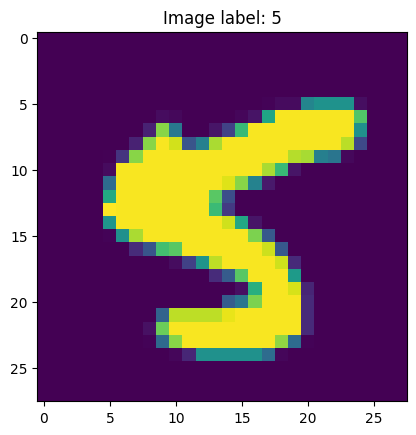

In [5]:
random_batch = next(iter(train_loader))
_image, _label = random_batch[0][0], random_batch[1][0]
plt.figure()
plt.imshow(_image.numpy().reshape(28, 28))
plt.title(f'Image label: {_label}')

In [45]:
number_shape = dataset.shape[-1] - 1

model = keras.models.Sequential(
    (
        keras.layers.Input(shape=(number_shape,)),
        keras.layers.Dense(number_shape//2, activation=keras.activations.relu, kernel_regularizer=keras.regularizers.l2(1e-4)),
        keras.layers.Dense(number_shape//4, activation=keras.activations.relu, kernel_regularizer=keras.regularizers.l2(1e-4)),
        keras.layers.Dense(50, activation=keras.activations.relu),
        keras.layers.Dense(10),
    )
)

model.compile(
    optimizer=keras.optimizers.Nadam(
        learning_rate=keras.optimizers.schedules.PolynomialDecay(
            initial_learning_rate=1e-2,
            decay_steps=1000,
            end_learning_rate=1e-4,
        ),
    ),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[
        keras.metrics.SparseCategoricalAccuracy(),
    ]
)

Epoch 1/20
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 0.5614 - sparse_categorical_accuracy: 0.8576 - val_loss: 0.2190 - val_sparse_categorical_accuracy: 0.9680
Epoch 2/20
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 0.1956 - sparse_categorical_accuracy: 0.9749 - val_loss: 0.2069 - val_sparse_categorical_accuracy: 0.9701
Epoch 3/20
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 0.1774 - sparse_categorical_accuracy: 0.9783 - val_loss: 0.1997 - val_sparse_categorical_accuracy: 0.9706
Epoch 4/20
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 0.1675 - sparse_categorical_accuracy: 0.9795 - val_loss: 0.1897 - val_sparse_categorical_accuracy: 0.9713
Epoch 5/20
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 0.1516 - sparse_categorical_accuracy: 0.9833 - val_loss: 0.1796 - val_sparse_categorical_accuracy: 0.9726
Epoch 6/20
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 0.1466 - sparse_categorical_accuracy: 0.9821 - val_loss: 0.1721 - val_sparse_categorical_accuracy

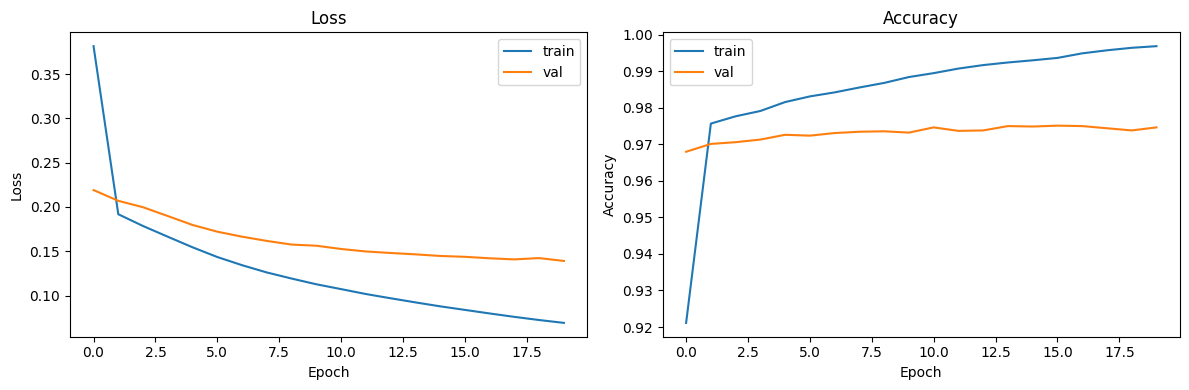

In [46]:
history = model.fit(train_loader, validation_data=test_loader, epochs=20)
plot_history(history)

## Results
### 2 Dense layers 128 -> 32, relu activation
epochs: 15
Nadam optimizer with lr = 1e-3
training time: 1m 6s
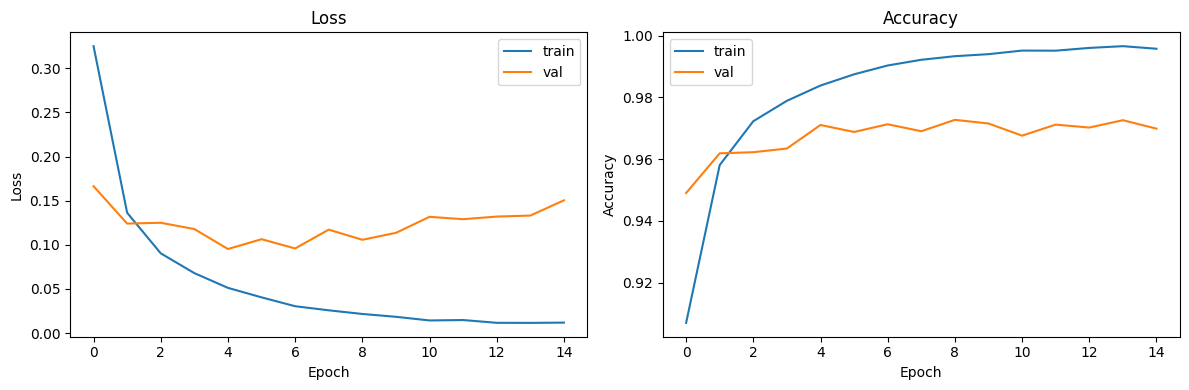

#### Add learning rate decay
Nadam optimizer with PolynomialDecay rate [1e-2; 1e-4]
training time: 1m 6s
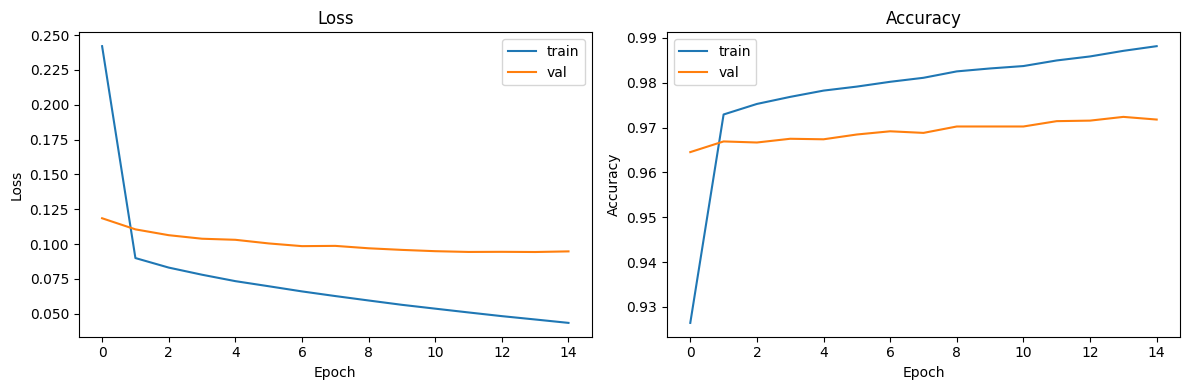

#### Add L1 regularization
layer1 regularization: L1(1e-4)
training time: 1m 10s
loss: 0.1708 - sparse_categorical_accuracy: 0.9833
val_loss: 0.1987 - val_sparse_categorical_accuracy: 0.9717
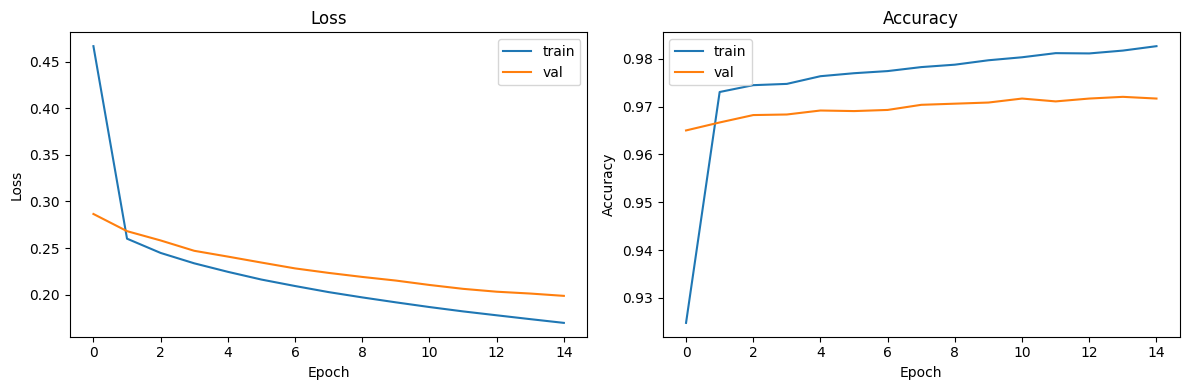

#### Switch to L2 regularization
layer1 regularization: L2(1e-4)
training time: 1m 14s
loss: 0.0803 - sparse_categorical_accuracy: 0.9898
val_loss: 0.1287 - val_sparse_categorical_accuracy: 0.9736
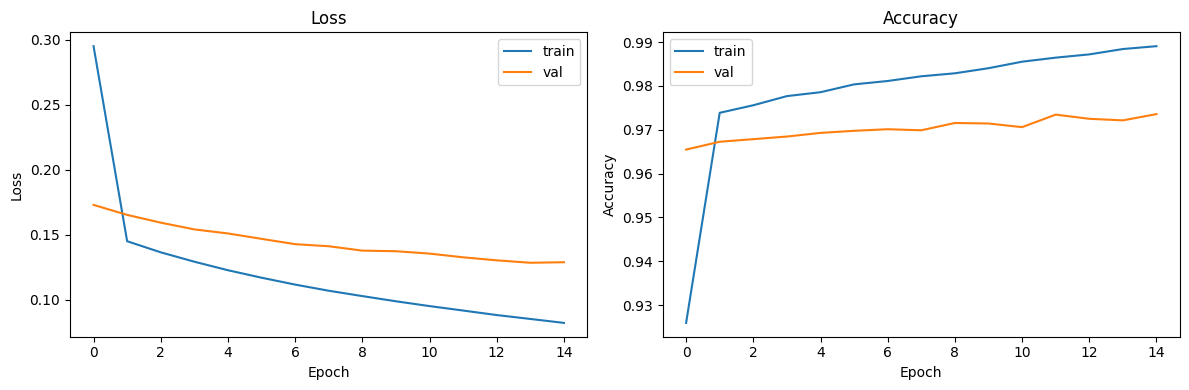

#### Add layer2 regularization, increase epochs
layer1 regularization: L1(1e-5)
layer1 regularization: L2(1e-4)
epochs: 20
training time: 1m 36s
loss: 0.0785 - sparse_categorical_accuracy: 0.9916
val_loss: 0.1344 - val_sparse_categorical_accuracy: 0.9721
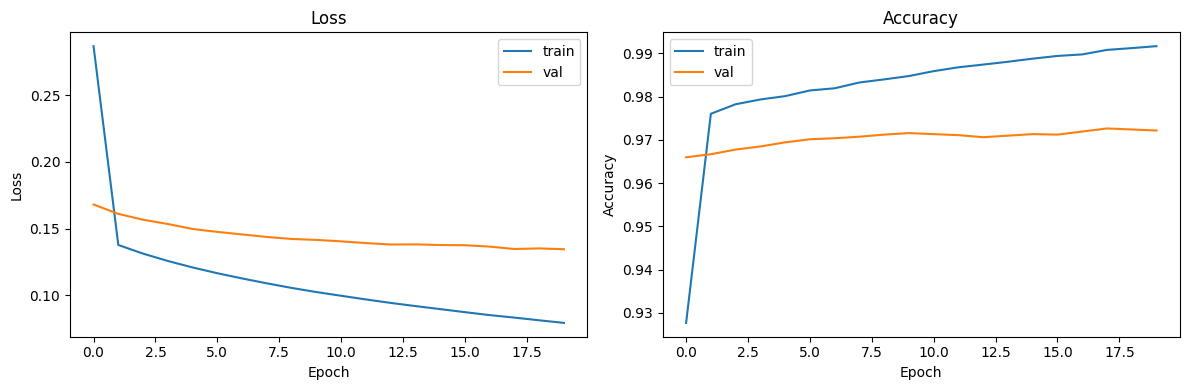

#### Change layers
layer1 vector_shape/2, regularization: L1(1e-5)
layer2 vector_shape/4, regularization: L2(1e-4)
layer3 50
training time: 2m 38s
loss: 0.0760 - sparse_categorical_accuracy: 0.9968
val_loss: 0.1577 - val_sparse_categorical_accuracy: 0.9749
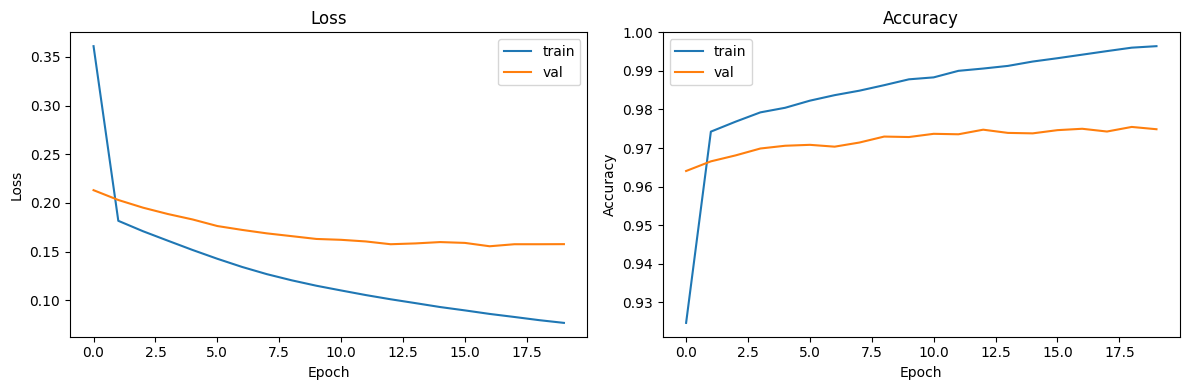

#### Switch to L2(1e-4) for both layers (final architecture)
training time: 2m 38s
loss: 0.0686 - sparse_categorical_accuracy: 0.9980
val_loss: 0.1447 - val_sparse_categorical_accuracy: 0.9754
training time: 2m 47s
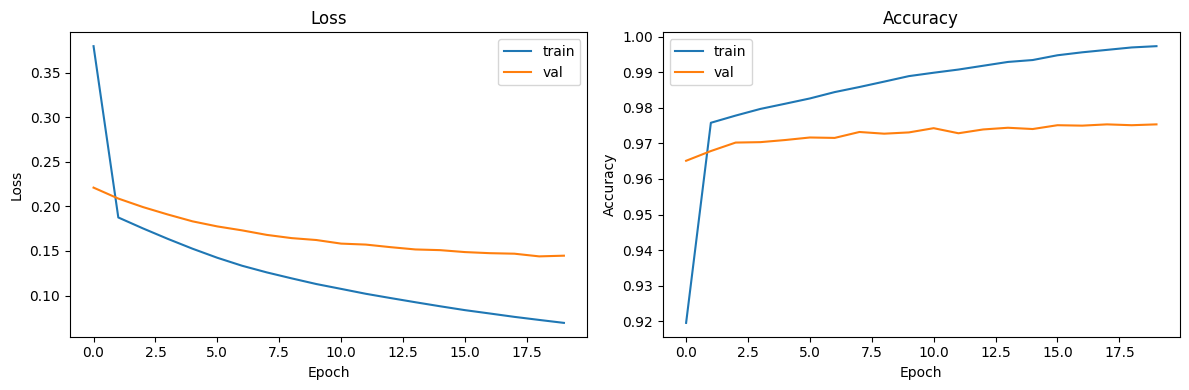

#### Add layer3 reg: L2(1e-4), increase epochs
epochs: 25
training time: 3m 25s
loss: 0.0603 - sparse_categorical_accuracy: 0.9993
val_loss: 0.1511 - val_sparse_categorical_accuracy: 0.9740

#### Change layer3 reg, change learning rate
Polynomial Decay [1e-2; 1e-5]
layer3 regularization: L2(1e-5)
training time: 3m 22s
loss: 0.1428 - sparse_categorical_accuracy: 0.9801
val_loss: 0.1776 - val_sparse_categorical_accuracy: 0.9696
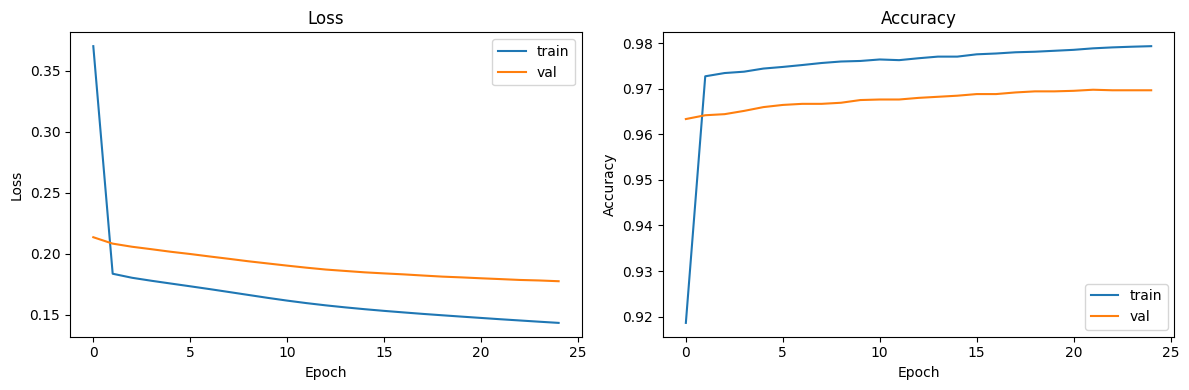

In [50]:
dataset = pd.read_csv(os.path.join(_DIR, _TEST_FILENAME))
images = dataset.astype('float32') / 255.0

predictions = model.predict(images.values)
ids = np.arange(1, len(predictions) + 1)

result = pd.DataFrame({
    'ImageId': ids,
    'Label': np.argmax(predictions, axis=1),
})

result.to_csv(_RESULT_FILENAME, index=False)

875/875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
